# Example calculations of waveguide dispersion using MEEP and subsequent supercontinuum generation simulation using PyNLO

In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from TFW_meep import waveguide_dispersion as wg
from TFW_meep import materials as mtp
import meep as mp
import meep.materials as mt
import scipy.constants as sc
%matplotlib inline

In [3]:
# n = squrt[epsilon] so epsilon = n^2
def eps_func_wvgd(omega):
    # omega is in inverse micron
    um = 1e-6
    v = omega * sc.c / um
    return n_MgLN_G(v, T=24.5, axis="e") ** 2


def n_MgLN_G(v, T=24.5, axis="e"):
    """
    Range of Validity:
        - 500 nm to 4000 nm
        - 20 C to 200 C
        - 48.5 mol % Li
        - 5 mol % Mg

    Gayer, O., Sacks, Z., Galun, E. et al. Temperature and wavelength
    dependent refractive index equations for MgO-doped congruent and
    stoichiometric LiNbO3 . Appl. Phys. B 91, 343–348 (2008).

    https://doi.org/10.1007/s00340-008-2998-2

    """
    if axis == "e":
        a1 = 5.756  # plasmons in the far UV
        a2 = 0.0983  # weight of UV pole
        a3 = 0.2020  # pole in UV
        a4 = 189.32  # weight of IR pole
        a5 = 12.52  # pole in IR
        a6 = 1.32e-2  # phonon absorption in IR
        b1 = 2.860e-6
        b2 = 4.700e-8
        b3 = 6.113e-8
        b4 = 1.516e-4
    elif axis == "o":
        a1 = 5.653  # plasmons in the far UV
        a2 = 0.1185  # weight of UV pole
        a3 = 0.2091  # pole in UV
        a4 = 89.61  # weight of IR pole
        a5 = 10.85  # pole in IR
        a6 = 1.97e-2  # phonon absorption in IR
        b1 = 7.941e-7
        b2 = 3.134e-8
        b3 = -4.641e-9
        b4 = -2.188e-6

    else:
        raise ValueError("axis needs to be o or e")

    wvl = sc.c / v * 1e6  # um
    f = (T - 24.5) * (T + 570.82)
    n2 = (
        (a1 + b1 * f)
        + (a2 + b2 * f) / (wvl**2 - (a3 + b3 * f) ** 2)
        + (a4 + b4 * f) / (wvl**2 - a5**2)
        - a6 * wvl**2
    )
    return n2**0.5

In [4]:
# %% create sim instance
etch_width = 1.245
etch_depth = 0.7
resolution = 30
sim = wg.ThinFilmWaveguide(
    etch_width=etch_width,
    etch_depth=etch_depth,
    film_thickness=1,
    substrate_medium=mtp.Al2O3,
    waveguide_medium=mt.LiNbO3,
    resolution=resolution,
    cell_width=10,
    cell_height=4,
)

In [5]:
%%capture
res = sim.calc_dispersion(0.4, 5, 100, eps_func_wvgd=eps_func_wvgd)  # simulate

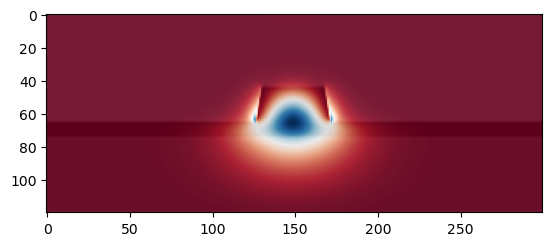

In [6]:
%matplotlib inline 
plt.imshow(res.eps[::-1, ::-1].T, cmap='binary')
plt.imshow(res.power[5][::-1, ::-1, mp.Y].T, cmap='RdBu', alpha=0.9)

In [7]:
um = 1e-6
v_grid = res.freq * sc.c / um
w_grid = v_grid * 2 * np.pi
k = res.kx.flatten()
b = k * 2 * np.pi / um  # beta is angular wavenumber
b_1 = np.gradient(b, (w_grid), edge_order=2)
b_2 = np.gradient(b_1, (w_grid), edge_order=2)

Text(0, 0.5, '$\\mathrm{\\beta_2} \\; (\\mathrm{ps^2/km})$')

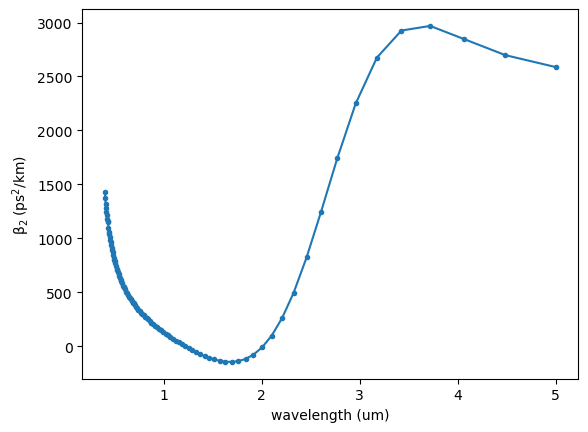

In [8]:
ps = 1e-12
km = 1e3
plt.plot(1 / res.freq, b_2 / (ps ** 2 / km), '.-')
plt.xlabel("wavelength (um)")
plt.ylabel("$\mathrm{\\beta_2} \; (\mathrm{ps^2/km})$")

In [9]:
import pynlo_extras as pe
from scipy.integrate import simpson
from scipy.interpolate import interp1d

In [10]:
ind_wl = np.argmin(abs(1.55 - 1 / res.freq))
power = res.power[ind_wl][:, :, mp.Y]
a_eff = simpson(simpson(power)) ** 2 / simpson(simpson(power ** 2)) * (um / resolution) ** 2

In [11]:
n_points = 2 ** 11
v_min = v_grid.min()
v_max = v_grid.max()
v0 = sc.c / 1550e-9
e_p = 100e-12
t_fwhm = 50e-15
time_window = 10e-12
pulse = pe.utilities.Pulse.Sech(n_points, v_min, v_max, v0, e_p, t_fwhm, time_window)

changing n_points from 2048 to 6912 to support both time and frequency bandwidths


In [12]:
beta = interp1d(v_grid, b, kind='cubic', fill_value="extrapolate")(pulse.v_grid)
length = 10e-3
polling_period = None
ppln = pe.materials.PPLN()
model = ppln.generate_model(pulse, a_eff, length, polling_period=polling_period, beta=beta, is_gaussian_beam=False)

In [13]:
z_grid = length
dz = pe.utilities.estimate_step_size(model)
res = model.simulate(z_grid, dz=dz, n_records=100)

/Users/peterchang/miniconda3/envs/idp/lib/python3.8/site-packages/pynlo_extras/utilities.py:308: RuntimeWarning: divide by zero encountered in log10
  p_t_dB = 10 * np.log10(np.abs(a_t) ** 2)
/Users/peterchang/miniconda3/envs/idp/lib/python3.8/site-packages/pynlo_extras/utilities.py:321: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


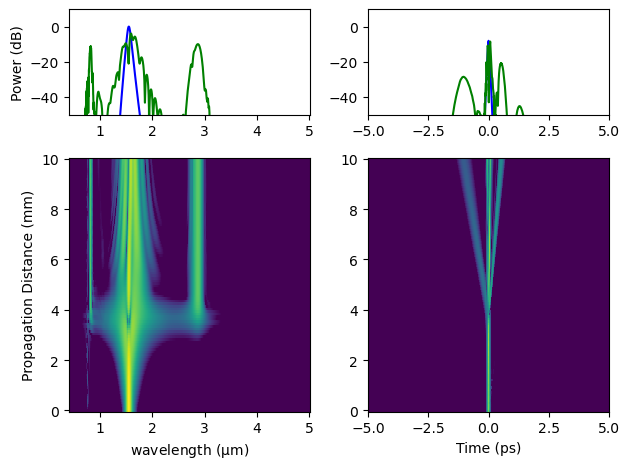

In [14]:
res.plot("wvl")

Text(0, 0.5, 'phase mismatch ($\\mathrm{1/\\mu m}$)')

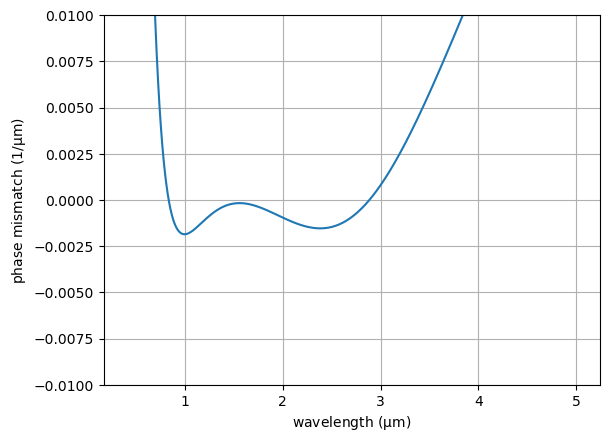

In [15]:
dk = model.dispersive_wave_dk
plt.plot(pulse.wl_grid * 1e6, dk.real * um / (2 * np.pi))
plt.ylim(-.01, .01)
plt.grid()
plt.xlabel("wavelength ($\\mathrm{\\mu m}$)")
plt.ylabel("phase mismatch ($\\mathrm{1/\\mu m}$)")